# Yield Curve - Principal Component Analysis



In [ ]:
!pip install pmdarima
!pip install factor-analyzer
import pandas as pd
import numpy as np

import io
from google.colab import files

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id = "2"></a><h1 id="Loading Data"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Loading Data</span></h1>

In [ ]:
uploaded = files.upload()
maturities = np.array([1/12, 2/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30])
df = pd.read_csv(io.BytesIO(uploaded['PCA_yield_curve.csv']), parse_dates = ["date"], index_col="date")
df.head()

Saving PCA_yield_curve.csv to PCA_yield_curve (6).csv


,eur001mindex,eur002mindex,eur003mindex,eur006mindex,eur009mindex,eusa1fcurncy,eusa2curncy,eusa3curncy,eusa4curncy,eusa5curncy,eusa6curncy,eusa7curncy,eusa8curncy,eusa9curncy,eusa10curncy,eusa12curncy,eusa15curncy,eusa20curncy,eusa30curncy
date,,,,,,,,,,,,,,,,,,,
Jan.99,3.119,3.097,3.074,3.011,2.989,2.990,3.0150,3.140,3.287,3.446,3.5890,3.6940,3.827,3.936,4.0240,4.184,4.3740,4.580,4.760
Feb.99,3.120,3.109,3.098,3.055,3.048,3.060,3.2525,3.396,3.624,3.762,3.9315,4.0365,4.143,4.261,4.3315,4.503,4.7025,4.922,5.122
Mar.99,2.992,2.980,2.971,2.950,2.961,2.984,3.0300,3.192,3.396,3.592,3.7860,3.9840,4.154,4.293,4.3900,4.545,4.7500,4.959,5.150
Apr.99,2.568,2.577,2.583,2.604,2.663,2.785,2.8360,3.005,3.256,3.457,3.6510,3.8700,4.046,4.192,4.3070,4.473,4.6870,4.923,5.103
May.99,2.566,2.572,2.578,2.596,2.663,2.802,2.9460,3.166,3.370,3.590,3.7970,3.9970,4.175,4.329,4.4420,4.632,4.8570,5.092,5.237


## Data Exploration
The data represents wide format of panel data on EUR Yield Curve in %. The yield curve is relationship between annual yield to maturity (="annual interest rate") of interest rate assets like bonds, swaps, etc. In general, government bond with maturity (maturity = "time when money are paid back") in 5 years pays different yield to bond with maturity in 15 years. The dataset contains yields for maturity starting at 1 month up to 30 years.


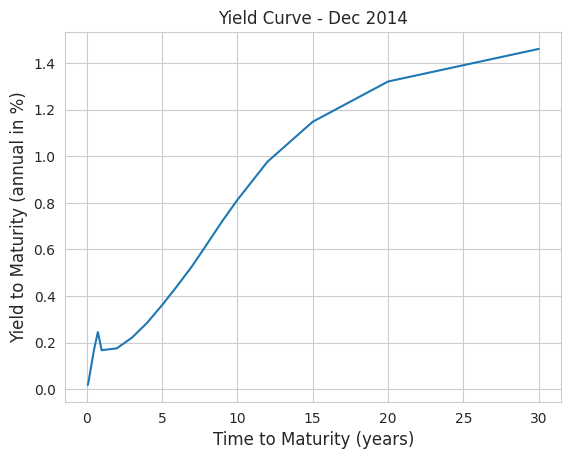

In [ ]:
yield_curve_example = df.iloc[-1].to_numpy()
plt.plot(maturities, yield_curve_example)
plt.xlabel('Time to Maturity (years)', size = 12)
plt.ylabel('Yield to Maturity (annual in %)', size = 12)
plt.title('Yield Curve - Dec 2014')
plt.show()

<Axes: xlabel='date'>

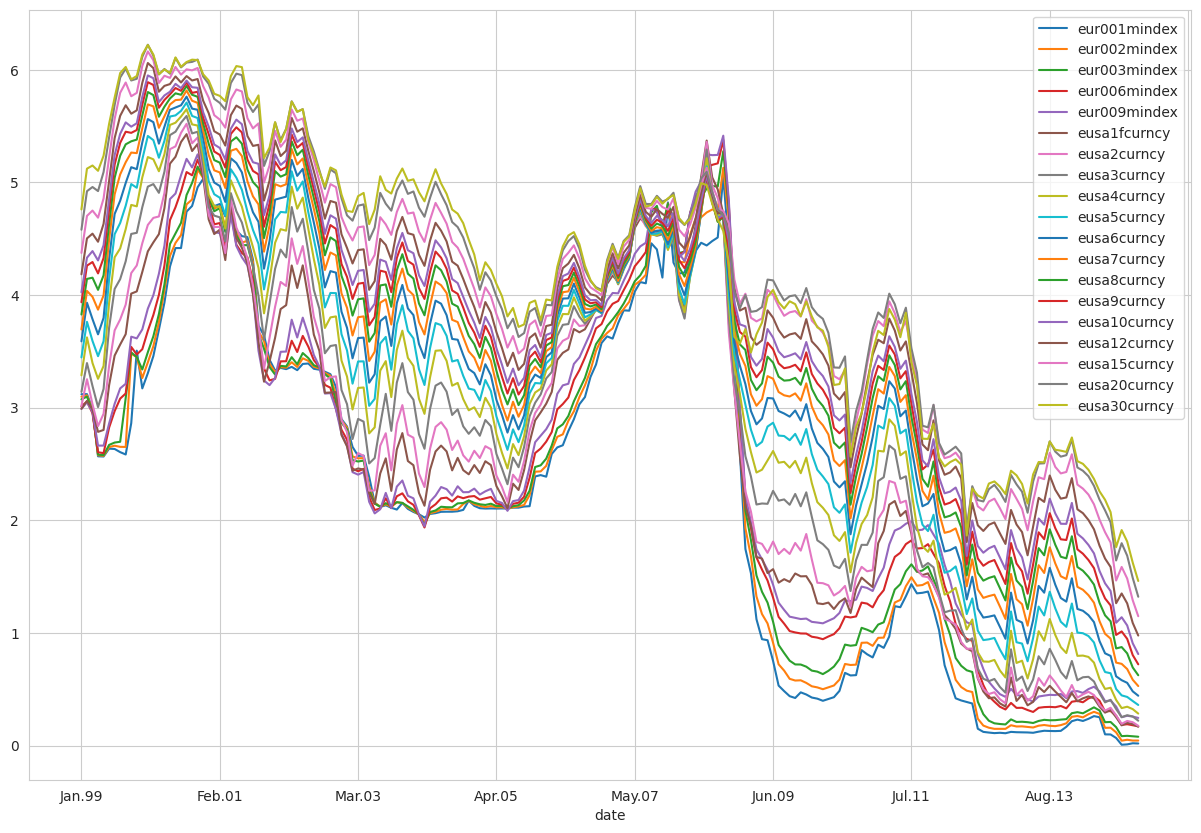

In [ ]:
df.plot(figsize=(15, 10))

# Principal Component Analysis (PCA)



# Suitability of PCA

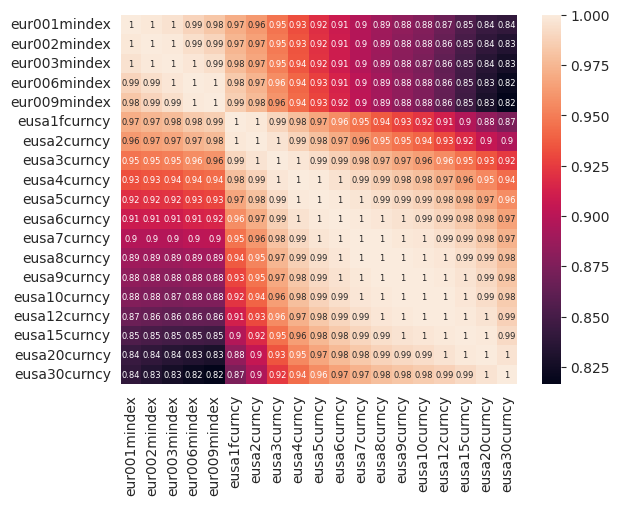

In [ ]:
# Calculates correlation matrix
corr_matrix = df.corr()

# Plot correlation matrix as heatmap
sns.heatmap(corr_matrix, annot=True, annot_kws={'size': 6})
plt.show()

In [ ]:
kmo_all, kmo_model = calculate_kmo(df)
print('Kaiser-Meyer-Olkin: {}'.format(round(kmo_model, 3)))

Kaiser-Meyer-Olkin: 0.936


The data seems to be perfect for performing PCA. There is no variable that wouldn't be correlated with some others, therefore, we do not have to exclude any variable.

## PCA

In [ ]:
pca = PCA(whiten=True) # Whiten controls scaling, True - data are standardized, False - data are not scaled
pca.fit(df)

PCA(whiten=True)

Explained variability scree plot

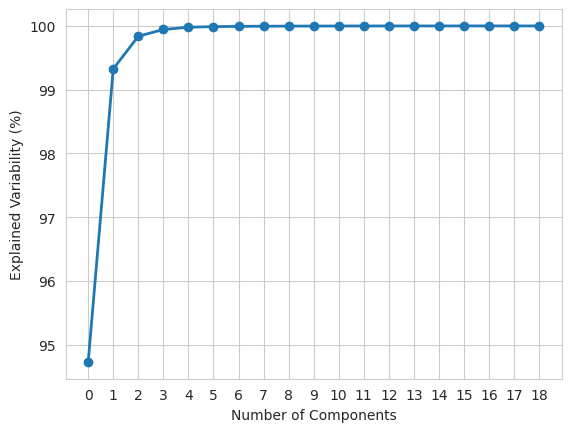

In [ ]:
explained_variance = pca.explained_variance_ratio_.cumsum()
components = np.arange(len(explained_variance))
plt.plot(components, explained_variance*100, 'o-', linewidth=2)
plt.xticks(components)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variability (%)")
plt.show()

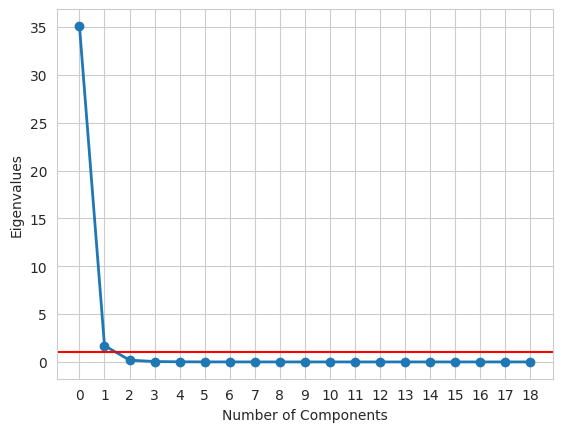

In [ ]:
eigen_values = pca.explained_variance_
components = np.arange(len(explained_variance))
plt.plot(components, eigen_values, 'o-', linewidth=2)
plt.xticks(components)
plt.xlabel("Number of Components")
plt.ylabel("Eigenvalues")
plt.axhline(y = 1, color = 'r', linestyle = '-') # Horizontal line - threshold for selection
plt.show()

Scree plot of eigen values suggests that we should use 2 principal components. This will roughly explain 99.5% of variability.

In [ ]:
new_dataset = pd.DataFrame(pca.transform(df)[:, :2], columns = ["PC1", "PC2"]).set_index(df.index)
new_dataset.head()

,PC1,PC2
date,,
Jan.99,-0.283516,0.380352
Feb.99,-0.444885,-0.106107
Mar.99,-0.384826,-0.273464
Apr.99,-0.244561,-0.623111
May.99,-0.311826,-0.856071


# Interpretation

## Coefficients
$PC_1 = v_{11} Yield_{1M} + v_{12} Yield_{2M} + ...$

$PC_2 = v_{21} Yield_{1M} + v_{22} Yield_{2M} + ...$

In [ ]:
pd.DataFrame(pca.components_[:2,:], index=["PC1 coefficients", "PC2 coefficients"], columns = np.arange(1, 20))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
PC1 coefficients,-0.250856,-0.251065,-0.248938,-0.241378,-0.237195,-0.248517,-0.249971,-0.247659,-0.242869,-0.236390,-0.230044,-0.224491,-0.219329,-0.214484,-0.210018,-0.203043,-0.196771,-0.194067,-0.194824
PC2 coefficients,0.304670,0.317449,0.323049,0.310407,0.301245,0.167894,0.104783,0.010800,-0.058518,-0.107139,-0.144344,-0.174402,-0.195674,-0.210045,-0.220477,-0.236337,-0.256341,-0.276422,-0.283742




*   If any interest rate increases by one the PC1 decreases by roughly the same $/approx$ 0.19-0.25, i.e., the first component represent vertical position of the yield curve = **negative level**, we can multiple the PC1 by -1 to interpret it as **level**
*   The yields with low maturity have positive coefficients that are slowly but monotonically decreasing up to a point of being negative = PC2 represents **negative "slope"** of the yield curve, we can multiply PC2 by -1 to make it interpretable as **slope**



<Axes: xlabel='date'>

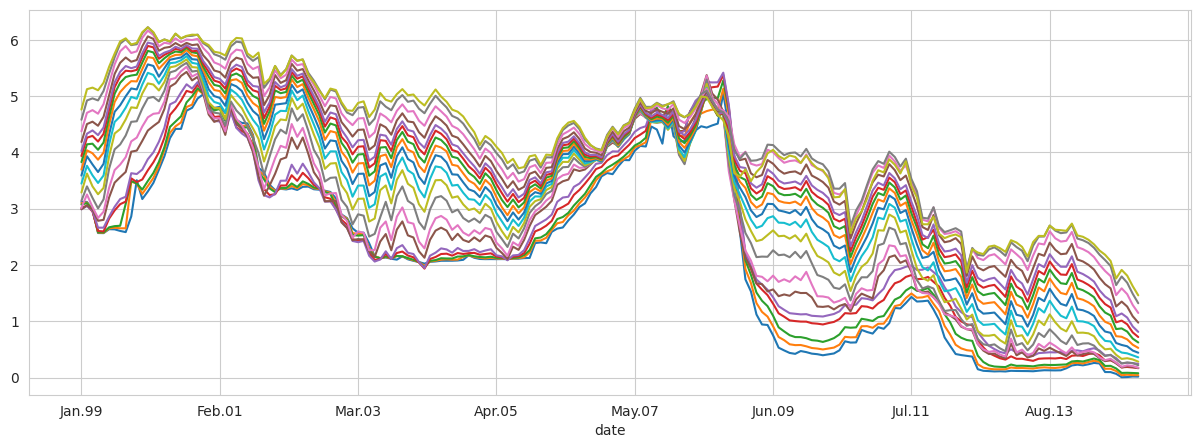

In [ ]:
# df.plot(figsize=(15, 10))
df.plot(figsize=(15, 5), legend = False)

<Axes: xlabel='date'>

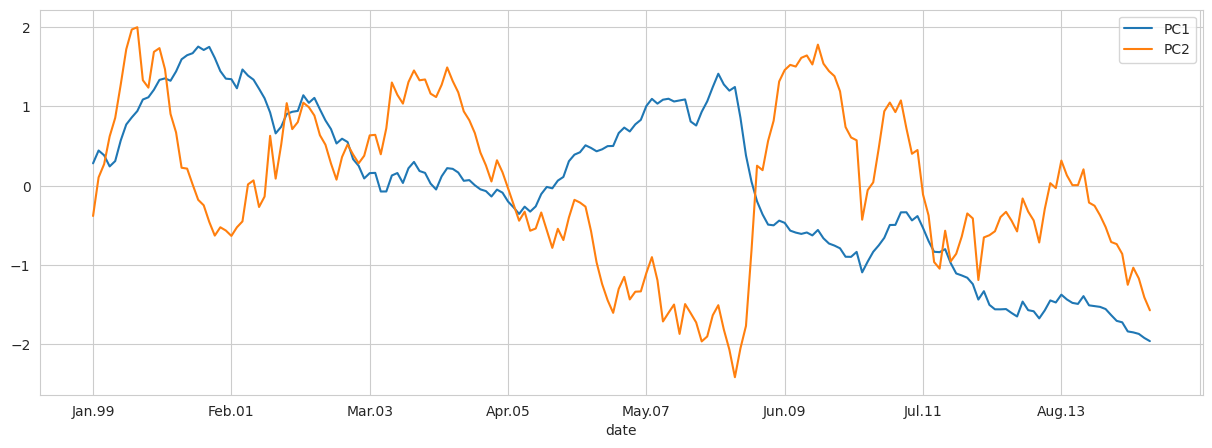

In [ ]:
(new_dataset*(-1)).plot(figsize=(15, 5))

## Yield Curve Reconstruction

<Axes: xlabel='date'>

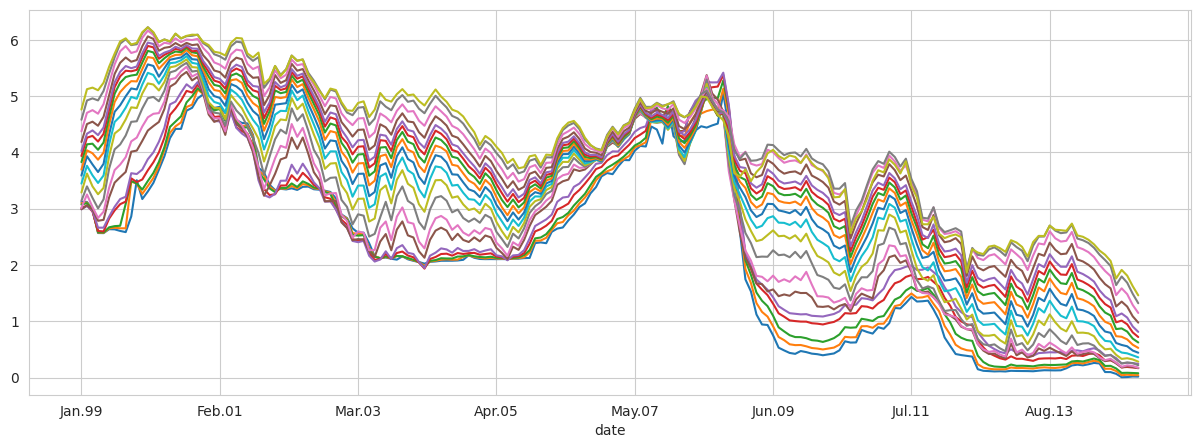

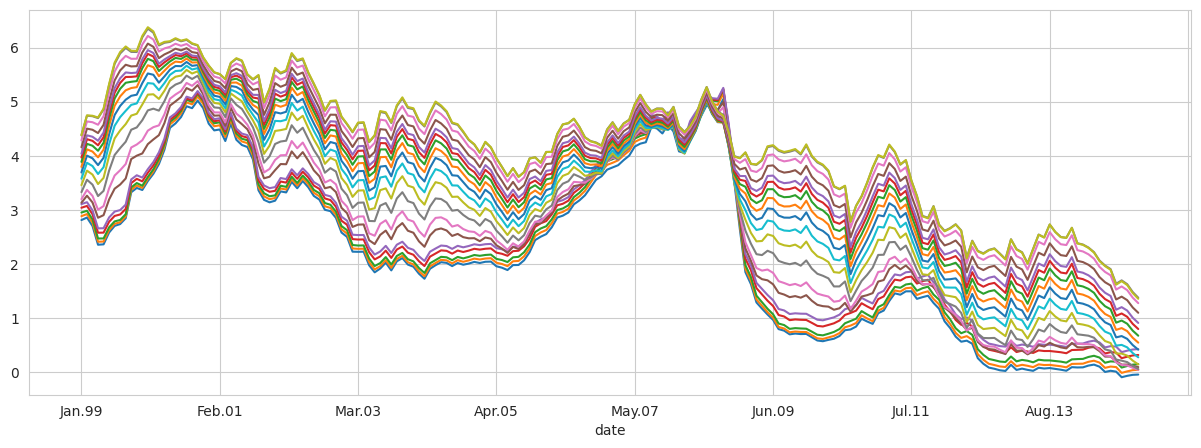

In [ ]:
pca_2 = PCA(n_components = 2, whiten=True) # PCA computed above includes all components, fit_transform and inverse_transform use all available - we want only first two
pca_2.fit(df)
PCs = pca_2.fit_transform(df)
reconstructed_df = pd.DataFrame(pca_2.inverse_transform(PCs), index = df.index, columns = df.columns) # reconstructed data from 2 PCs
df.plot(figsize=(15, 5), legend = False)
reconstructed_df.plot(figsize=(15, 5), legend = False)


# What next?
The components can be used for further modeling. For example, you could use ARIMAX with exogenous variables like GDP growth or inflation forecasted by central bank, forecast principle components and then using PCA coefficients reconstruct the future yield curve from the forecasted components.